In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 -index-url https://download.pytorch.org/whl/cu126

## Model

In [4]:
import torch
print(torch.__version__)


2.5.1+cu121


In [5]:
df = pd.read_csv('cleaned_emotion_classify_data.csv')
texts = df['Comment_clean'].astype(str).tolist()
labels = df['Emotion'].astype(str).tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

Classes: ['anger' 'fear' 'joy']


Dataset class

In [6]:
class TransformerTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        # remove extra batch dimension (squeeze)
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item


Training

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import numpy as np

def train_transformer_model(model_name, model_ckpt,
                            X_train_texts, y_train,
                            X_test_texts, y_test,
                            num_classes,
                            epochs=3,
                            batch_size=16,
                            max_len=64,
                            lr=2e-5):

    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    train_dataset = TransformerTextDataset(X_train_texts, y_train, tokenizer, max_len=max_len)
    test_dataset  = TransformerTextDataset(X_test_texts,  y_test,  tokenizer, max_len=max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=num_classes
    )
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * batch['input_ids'].size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

        epoch_loss = total_loss / total
        epoch_acc = correct / total
        print(f"[{model_name}] Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            labels = batch['labels']
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.numpy())

    acc = accuracy_score(all_targets, all_preds)
    report = classification_report(
        all_targets,
        all_preds,
        target_names=label_encoder.classes_,
        output_dict=True
    )
    print(f"[{model_name}] Test Accuracy: {acc:.4f}")
    return acc, report


c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
transformer_models = {
    # "BERT-base":    "bert-base-uncased",
    # "DistilBERT":   "distilbert-base-uncased",
    # "RoBERTa-base": "roberta-base",
    # "ALBERT":       "albert-base-v2",
    "MiniLM":       "microsoft/MiniLM-L12-H384-uncased"
}


In [9]:
results_tf = {}
EPOCHS = 3      # good starting point
BATCH_SIZE = 16
MAX_LEN = 64

for name, ckpt in transformer_models.items():
    print(f"\n=== Training {name} ({ckpt}) ===")
    acc, report = train_transformer_model(
        model_name=name,
        model_ckpt=ckpt,
        X_train_texts=X_train_texts,
        y_train=y_train,
        X_test_texts=X_test_texts,
        y_test=y_test,
        num_classes=num_classes,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        max_len=MAX_LEN,
        lr=2e-5
    )
    results_tf[name] = {
        'accuracy': acc,
        'report': report
    }



=== Training MiniLM (microsoft/MiniLM-L12-H384-uncased) ===


ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

In [ ]:
#

## Graphs

Accuracy comparison

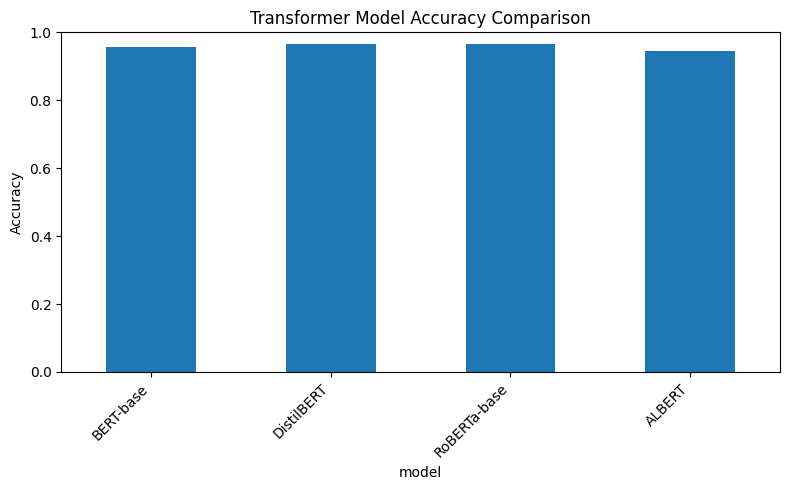

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Accuracy DataFrame for transformer models
acc_df = pd.DataFrame({
    'model': list(results_tf.keys()),
    'accuracy': [results_tf[m]['accuracy'] for m in results_tf]
}).set_index('model')

acc_df.plot(kind='bar', legend=False, figsize=(8,5))
plt.ylabel('Accuracy')
plt.title('Transformer Model Accuracy Comparison')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Macro precision, recall, F1 per model

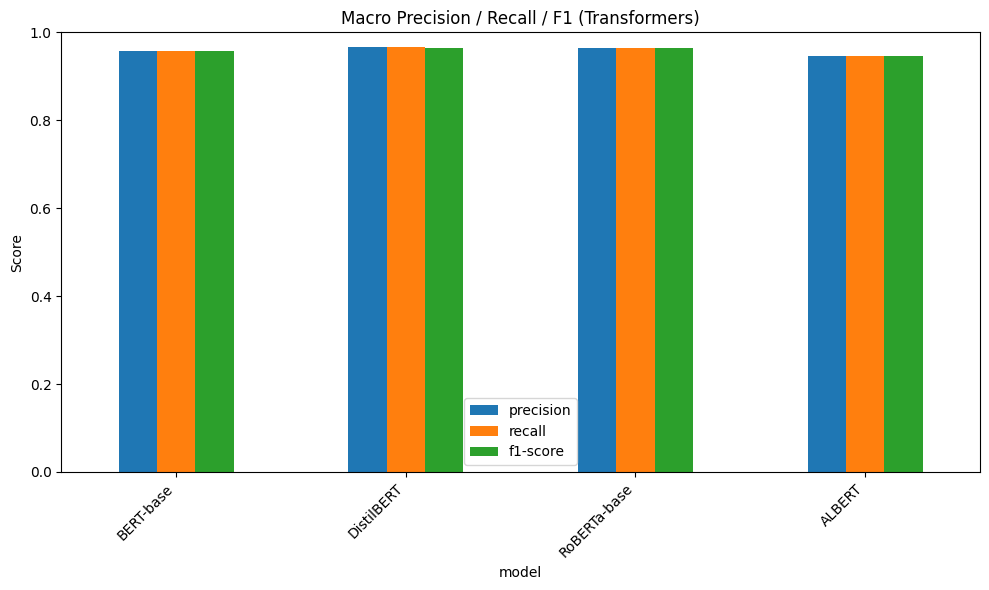

In [12]:
macro_df = pd.DataFrame({
    'model': list(results_tf.keys()),
    'precision': [results_tf[m]['report']['macro avg']['precision'] for m in results_tf],
    'recall':    [results_tf[m]['report']['macro avg']['recall'] for m in results_tf],
    'f1-score':  [results_tf[m]['report']['macro avg']['f1-score'] for m in results_tf],
}).set_index('model')

macro_df.plot(kind='bar', figsize=(10,6))
plt.ylabel('Score')
plt.title('Macro Precision / Recall / F1 (Transformers)')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Per-class F1-score comparison across models

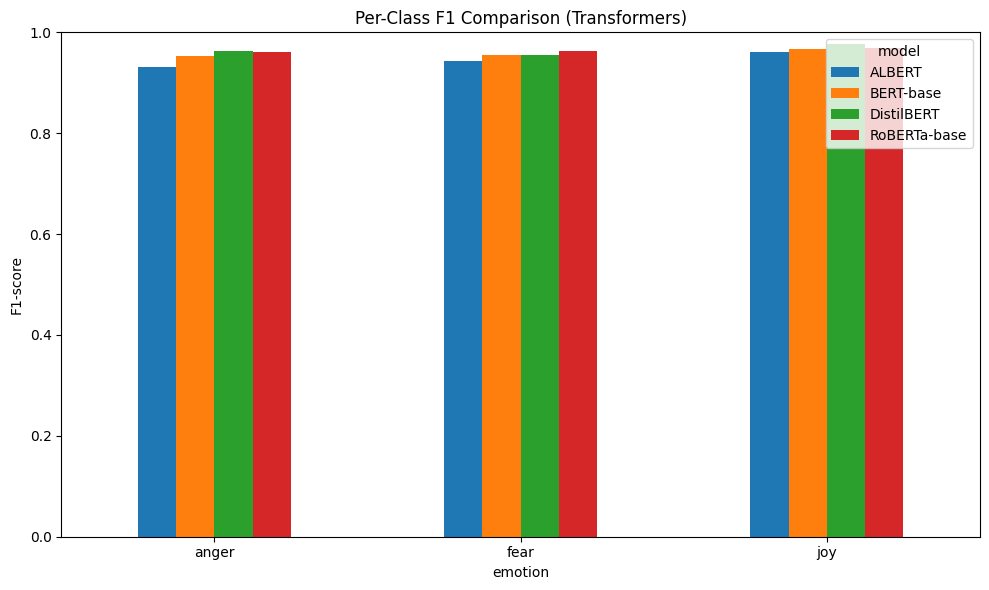

In [13]:
rows = []

for model, res in results_tf.items():
    for cls in label_encoder.classes_:
        rows.append({
            'model': model,
            'emotion': cls,
            'f1': res['report'][cls]['f1-score']
        })

df_f1 = pd.DataFrame(rows)

pivot_f1 = df_f1.pivot(index='emotion', columns='model', values='f1')

pivot_f1.plot(kind='bar', figsize=(10,6))
plt.ylabel('F1-score')
plt.title('Per-Class F1 Comparison (Transformers)')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
